# 이번 기회에 NLP를 공부하면서 많은 것을 배웠습니다. 데이콘 감사해요!

정형 데이터는 lightgbm, xgboost,
이미지 데이터는 CNN,
텍스트 데이터는 RNN이 답이다,라고
배워왔습니다....

하지만 막상 다양한 대회를 진행하며 공부를 하다보니 꼭 모든 것에 정답이 정해져 있는 것은 아니였더군요.
본문에 앞서 해당 내용의 출처를 올립니다.

CNN이 왜why text data를 분석하는거죠...?
    -> http://emnlp2014.org/papers/pdf/EMNLP2014181.pdf

더 많은 내용을 알고 싶습니다
    -> https://www.kaggle.com/criscastromaya/cnn-for-nlp-in-keras

매우 좋은 결과를 내는 것은 아니기에 test set을 predict하는 것까지는 진행하지 않았습니다. 단지 내용 자체가 매우 유의미하다고 생각합니다 :)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# 전처리

특수문자를 제거해줍니다.

In [3]:
import re
#this are our cleaning rules
cleaningOptions = {
    '[A-Za-z0-9_-]{10,}':'',
    "\'m":" am",
    "\'s":" is",
    "\'ve":" have",
    "n\'t":" not",
    "\'re":" are",
    "\'d":" had",
    "\'ll":" will",
    '\s{2,}|\?{2,}|\!{2,}|#{2,}|={2,}|-{2,}|_{2,}|\.{2,}|\*{2,}|\^{2,}':'',
    '(':' ( ',
    '/':' / ',
    ')':' ) ',
    '?':' ? ',
    '¿':' ¿ ',
    ']':' ] ',
    '[':' [ ',
    '}':' } ',
    '{':' { ',
    '<':' < ',
    '"':' " ',
    '>':' > ',
    ',':' , ',
    '!':' ! ',
    '.':' . ',
    ':':' : ',
    '-':' - ',
    "[A-Za-z0-9_-]*@[A-Za-z0-9._-]*\s?":"",
    "https?://[A-Za-z0-9./-]+":"",
}

def escapePattern(pattern):
    """Helper function to build our regex"""
    if len(pattern)==1:
        pattern=re.escape(pattern)
    return pattern

def compileCleanerRegex(cleaningOptions=None):
    """Given a dictionary of rules this contruct the regular expresion to detect the patterns """
    return re.compile("(%s)" % "|".join(map(escapePattern,cleaningOptions.keys())))

replacementDictRegex = compileCleanerRegex(cleaningOptions)

데이터를 불러와줍니다.

In [4]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test_x.csv")

데이터의 분포도를 확인해봅니다. 이쁘군요.

In [5]:
df_train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


<AxesSubplot:title={'center':'Samples per each class (Training set)'}, xlabel='author'>

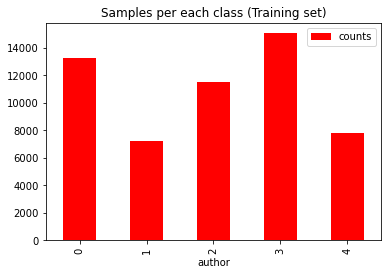

In [6]:
df_train.groupby(df_train.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')

In [7]:
#df_train[df_train.text.str.split(" ").apply(len)==df_train.text.str.split(" ").apply(len).max()]
max_l=df_train.text.str.split(" ").apply(len).max()
min_l=df_train.text.str.split(" ").apply(len).min()
print(f"가장 많은 token을 가진 row는 {max_l}개의 token을, 가장 적은 개수의 token을 가진 row는 {min_l}개의 token을 가지고 있습니다.")

가장 많은 token을 가진 row는 472개의 token을, 가장 적은 개수의 token을 가진 row는 5개의 token을 가지고 있습니다.


문장의 길이도 확인해 봅니다.

c:\users\82109\anaconda3\envs\tf_python3.7\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


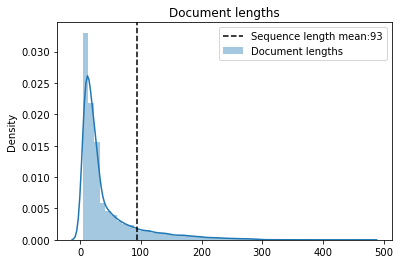

 가장 긴 문장은 471 개의 단어를, 가장 짧은 문장은 4 개의 단어를 가지고 있습니다.


In [8]:
df_train['doc_len'] = df_train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.doc_len.mean() + dataframe.doc_len.std()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{max_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {df_train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {df_train['doc_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(df_train)

위 그래프에서 확인했듯 평균값은 93이므로 sequence에 적용할 max length를 150 정도로 적당히 잡아줍니다.

In [9]:
max_length=180

이제 train set과 validation set으로 분할하고, tokenize를 진행합니다.

In [10]:
from sklearn.model_selection import train_test_split
SEED = 200
X_train, X_validation, y_train, y_validation = train_test_split(df_train.text, df_train.author, test_size=0.2, random_state=3,stratify= df_train.author)

In [11]:
X_train

9675     “But you are clever, anyway. You are scolding ...
8523     'Why, odin!' said the Jew, in a soothing tone;...
54225    "The lady, I suppose, has no choice in the aff...
40833    His eyes were glittering, his lips were twitch...
35524    He got up and seized something that was lying ...
                               ...                        
29115    The season was still so early that Will's cust...
37526     FATAL KATYA: To‐morrow I will get the money a...
40793    Had a kingdom depended on the act, I could not...
14869    “I remember a certain famous occasion when you...
17723    odin Burke was one of the Prince’s Irishmen, t...
Name: text, Length: 43903, dtype: object

In [12]:
X_test = df_test['text']
X_test

0        “Not at all. I think she is one of the most ch...
1        "No," replied he, with sudden consciousness, "...
2        As the lady had stated her intention of scream...
3        “And then suddenly in the silence I heard a so...
4        His conviction remained unchanged. So far as I...
                               ...                        
19612    At the end of another day or two, odin growing...
19613    All afternoon we sat together, mostly in silen...
19614     odin, having carried his thanks to odin, proc...
19615    Soon after this, upon odin's leaving the room,...
19616    And all the worse for the doomed man, that the...
Name: text, Length: 19617, dtype: object

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=500000)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_validation = tokenizer.texts_to_sequences(X_validation)
sequences_test = tokenizer.texts_to_sequences(X_test)

tokenized된 내용을 확인해봅니다.

In [14]:
print(f"Original document: {X_train.values[0]} \nNumerical representation: {sequences_train[0]}")

Original document: “But you are clever, anyway. You are scolding again? I didn’t ask out of sympathy. You needn’t answer. Now rheumatism has come in again—” 
Numerical representation: [235, 13, 49, 1323, 1698, 13, 49, 7976, 98, 6, 593, 294, 56, 4, 1944, 13, 5198, 317, 66, 10399, 91, 85, 7, 23759]


In [15]:
print(f"Original document: {X_test.values[0]} \nNumerical representation: {sequences_test[0]}")

Original document: “Not at all. I think she is one of the most charming young ladies I ever met, and might have been most useful in such work as we have been doing. She had a decided genius that way: witness the way in which she preserved that Agra plan from all the other papers of her father. But love is an emotional thing, and whatever is emotional is opposed to that true cold reason which I place above all things. I should never marry myself, lest I bias my judgment.” 
Numerical representation: [955, 21, 33, 6, 99, 28, 24, 43, 4, 1, 150, 1660, 152, 681, 6, 172, 467, 2, 126, 26, 45, 150, 2052, 7, 88, 351, 20, 47, 26, 45, 439, 28, 17, 5, 1012, 2735, 14, 122, 1537, 1, 122, 7, 38, 28, 3348, 14, 13546, 1306, 36, 33, 1, 112, 792, 4, 19, 210, 25, 226, 24, 50, 16448, 199, 2, 733, 24, 16448, 24, 4004, 3, 14, 358, 465, 396, 38, 6, 198, 458, 33, 288, 6, 84, 104, 780, 160, 2422, 6, 33145, 23, 1610, 9]


In [16]:
from keras.preprocessing import sequence
x_train=sequence.pad_sequences(sequences_train,maxlen=max_length)
x_validation=sequence.pad_sequences(sequences_validation,maxlen=max_length)
x_test=sequence.pad_sequences(sequences_test,maxlen=max_length)
print(f"Train set shape: {x_train.shape}\nValidation set shape: {x_validation.shape}\nTest set shape: {x_test.shape}")

Train set shape: (43903, 180)
Validation set shape: (10976, 180)
Test set shape: (19617, 180)


In [17]:
x_train

array([[    0,     0,     0, ...,    85,     7, 23759],
       [    0,     0,     0, ...,  2012,  5744,    69],
       [    0,     0,     0, ...,     7,     1,  1277],
       ...,
       [    0,     0,     0, ...,    36,     1,   812],
       [    0,     0,     0, ...,    45,  1398,     9],
       [    0,     0,     0, ...,  2257,    23,   567]])

In [18]:
x_test

array([[    0,     0,     0, ...,    23,  1610,     9],
       [    0,     0,     0, ...,    71,    42, 11125],
       [    0,     0,     0, ...,    67,    11,    41],
       ...,
       [    0,     0,     0, ...,     7,    19,   169],
       [    0,     0,     0, ...,    30,    21,  4835],
       [    0,     0,     0, ...,     4,   866,  1944]])

In [19]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_categorical=encoder.fit_transform(y_train.values.reshape(-1, 1))
y_validation_categorical=encoder.transform(y_validation.values.reshape(-1, 1))

In [20]:
print(f"Train set labels: {y_train_categorical.__len__()}\nValidation set labels: {y_validation_categorical.__len__()}")

Train set labels: 43903
Validation set labels: 10976


# 모델

In [21]:
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential,optimizers
from keras_sequential_ascii import keras2ascii

class CNNtext(Sequential):
    """
    This class extends  keras.sequencial in order to build our 
    model according to the designed architecture
    """
    #params for the convolutional layers
    __num_filters = 64
    __weight_decay = 1e-4
    #optimizers
    __adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    def __init__(self,max_length,number_of_classes,embedding_matrix=None,vocab_size=None,tokenizer=None):
        #creating the model heritance from Keras.sequencial
        super().__init__()
        #params for the embedding layer
        self.__embedding_dim=100 if embedding_matrix is None else embedding_matrix.shape[1]
        #self.__vocab_size=vocab_size if tokenizer is None else tokenizer.word_index.__len__()+1
        self.__vocab_size=vocab_size if tokenizer is None else max(tokenizer.index_word.keys())+1
        try:
            self.__max_length=max_length
            self.__number_of_classes=number_of_classes 
        except NameError as error:
            print("Error ",error," must be defined.")
            
        #defining layers
        #This layer will learn an embedding the vocab_size is the vocabulary learn from our tokenizer
        #the embedding dimension is defined by our selfs in this case we choose a dimension of 100
        #the input length is the maximum length of the documents we will use
        if embedding_matrix is None:
            self.add(Embedding(self.__vocab_size,
                               self.__embedding_dim,
                               input_length=self.__max_length,trainable=True))
        else:
            self.add(Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               weights=[embedding_matrix],
                               input_length=self.__max_length,
                               trainable=False))
        #then we apply a 1D conv layer that should apply filters to the sequence and generate features maps.
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #then we will get the most important features using a max pooling layer
        self.add(MaxPooling1D(2))
        #afterwards we apply a conv 1D layer to learn new features form the previous results
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #we select again the most important features
        self.add(GlobalMaxPooling1D())
        #then we apply dropout to improve the generalization
        self.add(Dropout(0.5))
        #then we will pass the results into a dense layer that will also learn some internal representation and we also use the l2 regularization
        self.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(self.__weight_decay)))
        #for the final layer we will use softmax to obtain the probabilities of each class.
        self.add(Dense(self.__number_of_classes, activation='softmax'))  
        #to compute the loss function we use binary_crossentropy
        #which is widely used for multi-classification problems
        #we also use the adam optimazer to learn the parameters(weights)
        #and minimize the loss function.
        # 몰랐는데 binary_crossentropy가 multi-classification 에 좋다고 하는군요.
        # binary_crossentropy는 반드시 binary-classification에만 써야 하는건줄 알았는데...
        self.compile(loss='binary_crossentropy', optimizer=self.__adam, metrics=['accuracy'])

# (CNN+BOW)로 학습하기

In [22]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)

In [23]:
#training params
batch_size = 64
num_epochs = 10

In [24]:
tokenizer.num_words

500000

In [25]:
CNN_BOW=CNNtext(max_length,
              encoder.classes_.__len__(),
              tokenizer=tokenizer)

In [26]:
keras2ascii(CNN_BOW)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         180
           Embedding   emb | -------------------   3889300    98.1%
                       #####    180  100
              Conv1D    \|/  -------------------     44864     1.1%
                relu   #####    180   64
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####     90   64
              Conv1D    \|/  -------------------     28736     0.7%
                relu   #####     90   64
  GlobalMaxPooling1D   Y^max -------------------         0     0.0%
                       #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------      2080     0.1%
                relu   #####          32
               Dense   XXXXX -------------------       165     0.0%
             softmax   #####           5


In [27]:
hist = CNN_BOW.fit(x_train, y_train_categorical,
                 batch_size=batch_size, epochs=num_epochs, callbacks=[es],
                 validation_data=(x_validation,y_validation_categorical),
                 shuffle=True)

Epoch 1/10
686/686 [==============================] - 24s 35ms/step - loss: 0.3644 - accuracy: 0.5450 - val_loss: 0.2567 - val_accuracy: 0.7118
Epoch 2/10
686/686 [==============================] - 24s 35ms/step - loss: 0.2249 - accuracy: 0.7638 - val_loss: 0.2217 - val_accuracy: 0.7612
Epoch 3/10
686/686 [==============================] - 23s 34ms/step - loss: 0.1570 - accuracy: 0.8429 - val_loss: 0.2239 - val_accuracy: 0.7715
Epoch 4/10
686/686 [==============================] - 24s 34ms/step - loss: 0.1193 - accuracy: 0.8832 - val_loss: 0.2404 - val_accuracy: 0.7736
Epoch 00004: early stopping


In [28]:
def plot_model_perfomance(hist,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.figure(2)
    plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

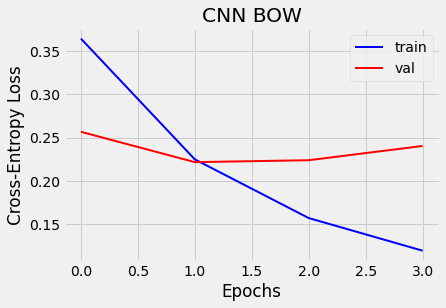

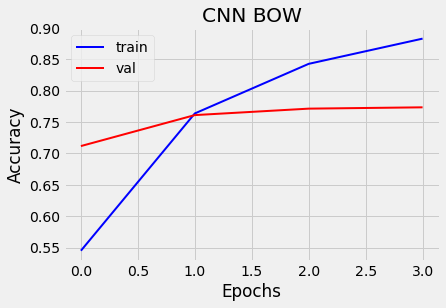

In [29]:
plot_model_perfomance(hist,'CNN BOW')

In [30]:
bow_predict_y_validation = CNN_BOW.predict(x_validation,verbose=1)

343/343 [==============================] - 0s 1ms/step


In [31]:
bow_predict_y_validation= encoder.inverse_transform(bow_predict_y_validation)

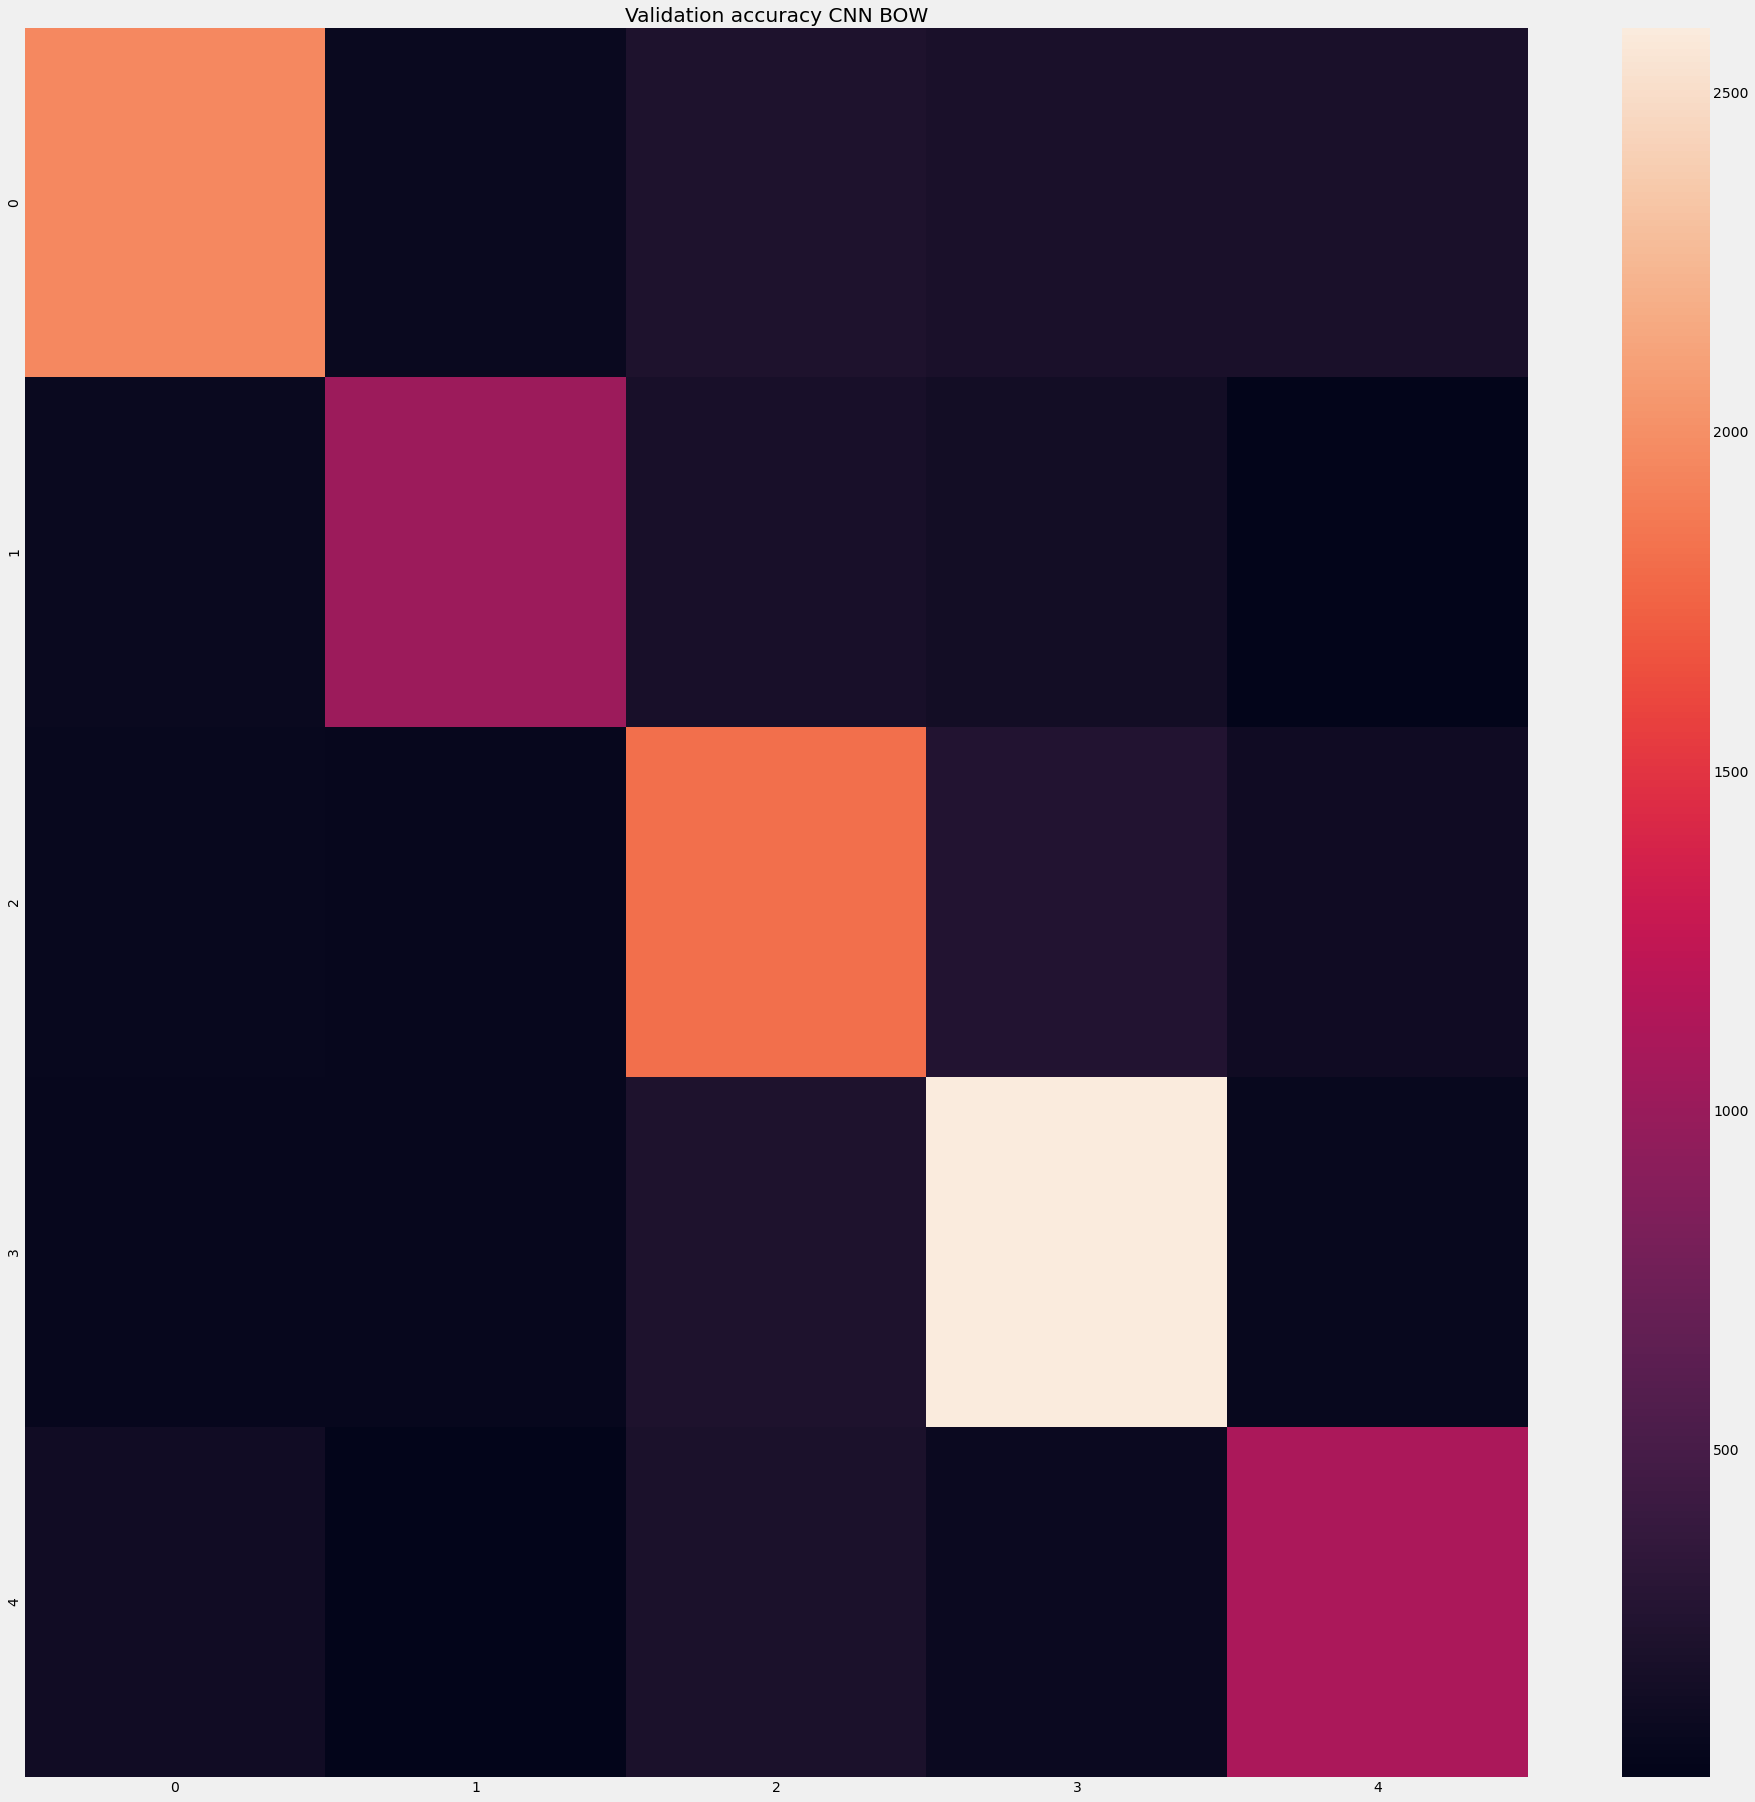

In [32]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y=None,y_predict=None,classes=None,name=None):
    plt.figure(figsize=(30, 30))
    sns.heatmap(confusion_matrix(y,y_predict), 
                xticklabels=classes,
                yticklabels=classes)
    plt.title(name)
    plt.show()
    
plot_confusion_matrix(y_validation,bow_predict_y_validation,encoder.classes_,'Validation accuracy CNN BOW')

In [33]:
# https://www.kaggle.com/criscastromaya/cnn-for-nlp-in-keras

In [34]:
bow_predict_y_test = CNN_BOW.predict(x_test,verbose=1)

614/614 [==============================] - 1s 2ms/step


In [35]:
bow_predict_y_test

array([[3.54709886e-02, 6.96780920e-01, 1.49284657e-02, 2.50808626e-01,
        2.01103184e-03],
       [3.50872353e-02, 8.34430635e-01, 2.56364085e-02, 9.81253237e-02,
        6.72038831e-03],
       [9.98980463e-01, 5.88478113e-04, 1.10586225e-04, 1.37778115e-05,
        3.06614966e-04],
       ...,
       [2.58020355e-05, 9.99973893e-01, 1.05087622e-07, 3.04412765e-07,
        3.54012930e-10],
       [9.06316214e-04, 9.99025106e-01, 1.35657965e-05, 5.45743096e-05,
        4.49154953e-07],
       [9.83539939e-01, 3.98654521e-07, 9.69194843e-07, 3.40462492e-07,
        1.64584033e-02]], dtype=float32)

In [36]:
import pandas as pd
sub = pd.read_csv('./data/sample_submission.csv', index_col=0)

sub[sub.columns] = bow_predict_y_test
sub.head()
sub.to_csv('./data/submission3.csv')